# Health Insurance fraud detection using Medicare Providers dataset : _'Medicare Provider Utilization and Payment Data: Physician and Other Supplier'_

https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gdown
from pathlib import Path

In [2]:
#Change directory to root
path = Path(os.getcwd())
root_dir = path.parent.absolute()
os.chdir(str(root_dir))

In [3]:
#Download raw data (not necessary if raw data is already downloaded)
data_2016 = gdown.download(id='10C_X5E5CFsMmbv2PHGzLyLMgkCEoJMPy',output='data/raw/CMS_2016.csv',quiet=False)
data_2017 = gdown.download(id="1CuQFIlTo1yDNsofJegD9O-M7YWTscBex",output='data/raw/CMS_2017.csv',quiet=False)
data_2018 = gdown.download(id="1CCPCiLPBYlxgE2sH9cwvhhN2esKe1N9w",output='data/raw/CMS_2018.csv',quiet=False)
data_2019 = gdown.download(id="1qE9rAZrbqNxQ2dEXm7WdFXf5UJ743BRP",output='data/raw/CMS_2019.csv',quiet=False)

Downloading...
From: https://drive.google.com/uc?id=10C_X5E5CFsMmbv2PHGzLyLMgkCEoJMPy
To: D:\Workspace\Projects\Medicare_Fraud_Detection\data\raw\CMS_2016.csv
100%|███████████████████████████████████████████████████████████████████████████████| 430M/430M [00:37<00:00, 11.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CuQFIlTo1yDNsofJegD9O-M7YWTscBex
To: D:\Workspace\Projects\Medicare_Fraud_Detection\data\raw\CMS_2017.csv
100%|███████████████████████████████████████████████████████████████████████████████| 443M/443M [00:39<00:00, 11.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CCPCiLPBYlxgE2sH9cwvhhN2esKe1N9w
To: D:\Workspace\Projects\Medicare_Fraud_Detection\data\raw\CMS_2018.csv
100%|███████████████████████████████████████████████████████████████████████████████| 456M/456M [00:39<00:00, 11.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qE9rAZrbqNxQ2dEXm7WdFXf5UJ743BRP
To: D:\Workspace\Projects\Medicare_Fraud_Detection\data\raw\CMS_2019.csv
100%

## 1. Data Preparation

In [4]:
#Read raw data
df_cms_2016 = pd.read_csv('data/raw/CMS_2016.csv',low_memory=False)
df_cms_2017 = pd.read_csv('data/raw/CMS_2017.csv',low_memory=False)
df_cms_2018 = pd.read_csv('data/raw/CMS_2018.csv',low_memory=False)
df_cms_2019 = pd.read_csv('data/raw/CMS_2019.csv',encoding = "ISO-8859-1",low_memory=False) 

### 1.1 Medicare Part B data

The database describes the services and procedures that health care professionals provide to Medicare beneficiaries. The records in the dataset contain various provider-level attributes, such as National Provider Identifier (NPI), first and last name, gender, address, etc.
In addition, the records contain information that describes a provider's Medicare activity in a given year. Examples include: the procedure performed, the average fee submitted to Medicare, the average amount paid by Medicare, and the location of service.


In [5]:
print('2016 shape :' ,df_cms_2016.shape)
print('2017 shape :' ,df_cms_2017.shape)
print('2018 shape :' ,df_cms_2018.shape)
print('2019 shape :' ,df_cms_2019.shape)

2016 shape : (1053958, 73)
2017 shape : (1088687, 73)
2018 shape : (1121462, 73)
2019 shape : (1155870, 73)


In [6]:
#Add year column
df_cms_2016['year']=2016
df_cms_2017['year']=2017
df_cms_2018['year']=2018
df_cms_2019['year']=2019

This database is aggregated at the NPI level, the identifier of a provider, and contains information for the years 2016 through 2019 with over one million records and 73 variables for each year, which makes this database an excellent candidate for data analysis and machine learning.

In [7]:
df_cms = pd.concat([df_cms_2016, df_cms_2017,df_cms_2018,df_cms_2019])

In [8]:
df_cms.shape

(4419977, 74)

The final database contains approximately 4.4 million records and 73 attributes.

As we're intrested in fraud detection, we kept only the most relevant columns/features in order to build our predective models, the feature selection was based mainly on state of the art results using the Medicare data.

In [9]:
#keep only relevant columns:
cols =  ['Rndrng_NPI','Rndrng_Prvdr_Type', 'Rndrng_Prvdr_State_Abrvtn'
         ,'Rndrng_Prvdr_Gndr','Tot_HCPCS_Cds', 'Bene_Male_Cnt','Bene_Avg_Age',
         'Tot_Srvcs','Tot_Benes','Bene_Avg_Risk_Scre',
         'Tot_Sbmtd_Chrg','Tot_Mdcr_Pymt_Amt','year']
df_cms=df_cms[cols].copy()

In [10]:
print('New shape :',df_cms.shape)

New shape : (4419977, 13)


In [11]:
df_cms.sort_values(by=['Rndrng_NPI'],inplace=True) #sort by NPI

In [12]:
df_cms.head(5)

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,year
0,1003000126,Internal Medicine,MD,M,23,232.0,75,1477.0,518,2.0239,746533.0,124795.99,2016
0,1003000126,Internal Medicine,MD,M,19,182.0,76,1218.0,445,2.2948,692640.0,102505.73,2018
0,1003000126,Internal Medicine,MD,M,18,265.0,75,1392.0,610,2.5917,519136.0,124877.67,2019
0,1003000126,Internal Medicine,MD,M,23,240.0,75,1670.0,578,2.1178,800850.0,137084.55,2017
1,1003000134,Pathology,IL,M,21,1703.0,76,7329.0,3322,1.0899,1143597.0,214070.99,2018


In [13]:
#Fix index
df_cms=df_cms.reset_index()
df_cms.drop('index', axis=1, inplace=True)

In [14]:
df_cms.head(5)

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,year
0,1003000126,Internal Medicine,MD,M,23,232.0,75,1477.0,518,2.0239,746533.0,124795.99,2016
1,1003000126,Internal Medicine,MD,M,19,182.0,76,1218.0,445,2.2948,692640.0,102505.73,2018
2,1003000126,Internal Medicine,MD,M,18,265.0,75,1392.0,610,2.5917,519136.0,124877.67,2019
3,1003000126,Internal Medicine,MD,M,23,240.0,75,1670.0,578,2.1178,800850.0,137084.55,2017
4,1003000134,Pathology,IL,M,21,1703.0,76,7329.0,3322,1.0899,1143597.0,214070.99,2018


In order to prepare this database for fraud detection, we need to add a label that indicates whether the provider is fraudulent or not, for this we need to use a second database, which associates fraud labels to the providers listed in the Medicare Part B database.

### 1.2 LEIE data

In [15]:
df_leie= pd.read_csv('data/raw/LEIE.csv',low_memory=False)

Actual Medicare provider fraud labels are identified using LEIE data.

LEIE is maintained by the OIG in accordance with sections 1128 and 1156 of the Social Security Act and is updated monthly. The OIG has the authority to exclude providers from federally funded health care programs for various reasons. Excluded individuals cannot receive payment from federal health programs for any services, and must apply for reinstatement once their exclusion period has expired. The current LEIE data format contains 18 attributes that describe the provider and the reason for the exclusion.

The LEIE exclusion type attribute is a categorical value that describes the reason a provider was excluded.
Following the work of Bauder and Khoshgoftaar (https://journalofbigdata.springeropen.com/articles/10.1186/s40537-018-0138-3), a subset of exclusion rules that are most indicative of fraud is selected to label Medicare providers.

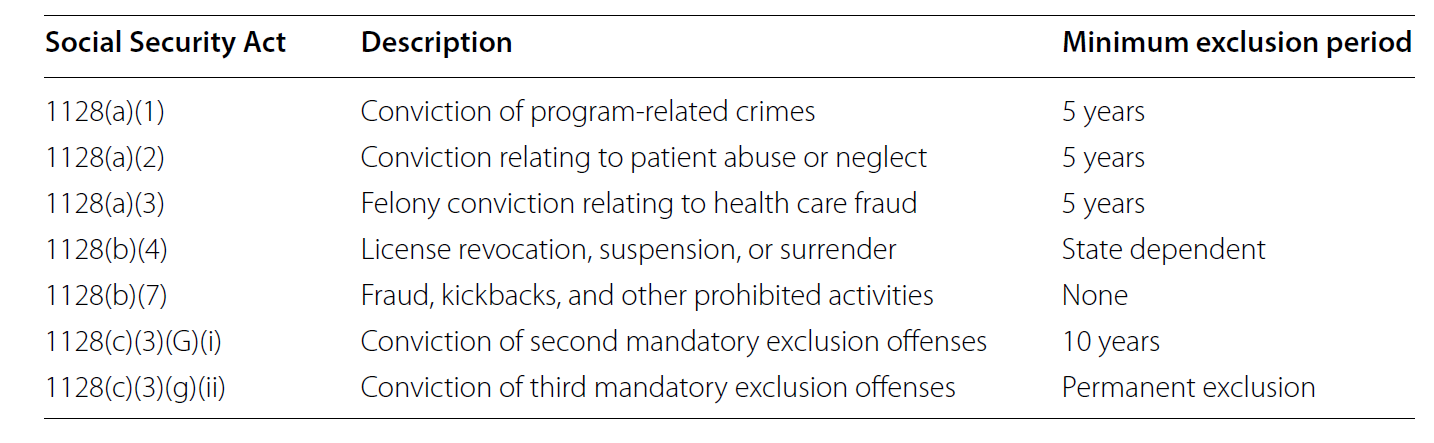

For providers in the Medicare Part B database, whose NPI number matches that in the LEIE database, claims prior to the date of the provider's exclusion are considered fraudulent, i.e., a provider's reimbursement activity prior to the date of its Medicare exclusion reflects fraudulent activity, since it was convicted shortly thereafter.

### 1.3 Labeling of the dataset

Fraudulent provider labels are generated by matching the NPI numbers of individuals excluded from the LEIE data set to the Medicare Part B data set.

In [16]:
df_leie.columns

Index(['LASTNAME', 'FIRSTNAME', 'MIDNAME', 'BUSNAME', 'GENERAL', 'SPECIALTY',
       'UPIN', 'NPI', 'DOB', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'EXCLTYPE',
       'EXCLDATE', 'REINDATE', 'WAIVERDATE', 'WVRSTATE'],
      dtype='object')

In [17]:
#delete unnecessary columns
droped_cols_leie = [col for col in df_leie.columns if col not in ['NPI','EXCLTYPE','EXCLDATE'
                                                                   ,'REINDATE', 'WAIVERDATE']]
df_leie.drop(droped_cols_leie, axis=1, inplace=True)

In [18]:
#drop NPI = 0
df_leie=df_leie[df_leie["NPI"]>0]

In [19]:
df_leie.head()

,NPI,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE
1,1972902351,1128b8,20220320,0,0
4,1922348218,1128a1,20180419,0,0
24,1942476080,1128b8,20170518,0,0
28,1275600959,1128a1,20130320,0,0
31,1891731758,1128b8,20170518,0,0


In [20]:
print('max Rein',df_leie['REINDATE'].max())
print('max Waiver',df_leie['WAIVERDATE'].max())

max Rein 0
max Waiver 20160218


In [21]:
#Drop REINDATE 
df_leie.drop('REINDATE', axis=1, inplace=True)
df_leie.head()

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE
1,1972902351,1128b8,20220320,0
4,1922348218,1128a1,20180419,0
24,1942476080,1128b8,20170518,0
28,1275600959,1128a1,20130320,0
31,1891731758,1128b8,20170518,0


In [22]:
df_leie['EXCLTYPE'].unique()

array(['1128b8', '1128a1', '1128b7', '1128b7   ', '1128a1   ', '1128b5',
       '1128a2', '1128a4', '1128b1', '1128a3', 'BRCH CIA', '1128b6   ',
       '1128b4', 'BRCH SA', '1128Aa', '1128b16', '1128b2   ', '1128b14',
       '1128a3   ', '1128b3', '1128a2   ', '1128b2', '1128b6',
       '1128a4   ', '1156', '1128b15', '1128b5   '], dtype=object)

In [23]:
df_leie['EXCLTYPE'] = df_leie['EXCLTYPE'].str.replace(' ', '')

In [24]:
#Keep relevant codes
droped_rows_leie = [row for row in df_leie['EXCLTYPE'].unique() if row not in ['1128a1','1128a2','1128a3'
                                                                   ,'1128b4','1128b7']]
for row in droped_rows_leie :
    df_leie.drop(df_leie[df_leie['EXCLTYPE'] == row].index, inplace = True)

In [25]:
list(df_leie['EXCLTYPE'].unique())

['1128a1', '1128b7', '1128a2', '1128a3', '1128b4']

In [26]:
df_leie.head()

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE
4,1922348218,1128a1,20180419,0
28,1275600959,1128a1,20130320,0
60,1851631543,1128b7,20190326,0
61,1902198435,1128a1,20160120,0
62,1073916631,1128b7,20210816,0


In [27]:
#Add exclusion period
df_leie['EXCLDATE_END']=0
df_leie.head()

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END
4,1922348218,1128a1,20180419,0,0
28,1275600959,1128a1,20130320,0,0
60,1851631543,1128b7,20190326,0,0
61,1902198435,1128a1,20160120,0,0
62,1073916631,1128b7,20210816,0,0


In [28]:
#Fix index
df_leie=df_leie.reset_index()
df_leie.drop('index', axis=1, inplace=True)
df_leie.head()

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END
0,1922348218,1128a1,20180419,0,0
1,1275600959,1128a1,20130320,0,0
2,1851631543,1128b7,20190326,0,0
3,1902198435,1128a1,20160120,0,0
4,1073916631,1128b7,20210816,0,0


In [29]:
#add sentence (5 years)
for idx,date in enumerate(list(df_leie['EXCLDATE'])):
    dt=str(date)
    yr=dt[:4]
    if  df_leie.loc[idx,"EXCLTYPE"] in ['1128a1',"1128a2","1128a3"]:
        exc_year=int(yr)+5
        df_leie.loc[idx,"EXCLDATE_END"]=str(exc_year)+dt[4:6]

In [30]:
df_leie[df_leie['WAIVERDATE']> 0]

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END
492,1871571406,1128a1,20160120,20160218,202101
2713,1205832227,1128a1,20100920,20140917,201509
3141,1285673012,1128a1,20150618,20150618,202006
3538,1114922606,1128a1,20110720,20110720,201607
4178,1427028638,1128a1,20120220,20120220,201702


In [31]:
#convert waiverdate (delete day)
for idx,date in enumerate(list(df_leie['WAIVERDATE'])):
    if df_leie.loc[idx,"WAIVERDATE"] > 0:
        dt=str(date)
        yr=dt[:4]
        df_leie.loc[idx,"WAIVERDATE"]=yr+dt[4:6]

In [32]:
df_leie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4939 entries, 0 to 4938
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   NPI           4939 non-null   int64 
 1   EXCLTYPE      4939 non-null   object
 2   EXCLDATE      4939 non-null   int64 
 3   WAIVERDATE    4939 non-null   object
 4   EXCLDATE_END  4939 non-null   object
dtypes: int64(2), object(3)
memory usage: 193.1+ KB


In [33]:
#convert types
df_leie["EXCLDATE"] = pd.to_numeric(df_leie["EXCLDATE"])
df_leie["WAIVERDATE"] = pd.to_numeric(df_leie["WAIVERDATE"])
df_leie["EXCLDATE_END"] = pd.to_numeric(df_leie["EXCLDATE_END"])

In [34]:
df_leie[df_leie['WAIVERDATE']> 0]

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END
492,1871571406,1128a1,20160120,201602,202101
2713,1205832227,1128a1,20100920,201409,201509
3141,1285673012,1128a1,20150618,201506,202006
3538,1114922606,1128a1,20110720,201107,201607
4178,1427028638,1128a1,20120220,201202,201702


In [35]:
#upadate final date (waiver / sentence)

df_leie['Final_date']=df_leie['EXCLDATE_END']
for idx,date in enumerate(list(df_leie['WAIVERDATE'])):
    if df_leie.loc[idx,"WAIVERDATE"] > 0 :
        df_leie.loc[idx,"Final_date"]=df_leie.loc[idx,"WAIVERDATE"]

In [36]:
df_leie[df_leie['WAIVERDATE'] > 0]

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END,Final_date
492,1871571406,1128a1,20160120,201602,202101,201602
2713,1205832227,1128a1,20100920,201409,201509,201409
3141,1285673012,1128a1,20150618,201506,202006,201506
3538,1114922606,1128a1,20110720,201107,201607,201107
4178,1427028638,1128a1,20120220,201202,201702,201202


In [37]:
df_leie.head()

,NPI,EXCLTYPE,EXCLDATE,WAIVERDATE,EXCLDATE_END,Final_date
0,1922348218,1128a1,20180419,0,202304,202304
1,1275600959,1128a1,20130320,0,201803,201803
2,1851631543,1128b7,20190326,0,0,0
3,1902198435,1128a1,20160120,0,202101,202101
4,1073916631,1128b7,20210816,0,0,0


In [38]:
#drop WAIVERDATE / EXCLDATE_END
droped_cols_leie2 = [col for col in df_leie.columns if col not in ['NPI','EXCLTYPE','EXCLDATE','Final_date']]
df_leie.drop(droped_cols_leie2, axis=1, inplace=True)

In [39]:
df_leie.head()

,NPI,EXCLTYPE,EXCLDATE,Final_date
0,1922348218,1128a1,20180419,202304
1,1275600959,1128a1,20130320,201803
2,1851631543,1128b7,20190326,0
3,1902198435,1128a1,20160120,202101
4,1073916631,1128b7,20210816,0


In [40]:
#rounding year

df_leie['Final_year']=0
df_leie=df_leie.reset_index()

for idx,date in enumerate(list(df_leie['Final_date'])):
    if df_leie.loc[idx,"Final_date"] > 0:
        dt=str(date)
        yr=dt[:4]
        mt=dt[4:]
        if (int(mt)>6):
            df_leie.loc[idx,"Final_year"] = int(yr)+1
        else :
            df_leie.loc[idx,"Final_year"] = int(yr)

In [41]:
df_leie=df_leie.reset_index()
df_leie.head(10)

,level_0,index,NPI,EXCLTYPE,EXCLDATE,Final_date,Final_year
0,0,0,1922348218,1128a1,20180419,202304,2023
1,1,1,1275600959,1128a1,20130320,201803,2018
2,2,2,1851631543,1128b7,20190326,0,0
3,3,3,1902198435,1128a1,20160120,202101,2021
4,4,4,1073916631,1128b7,20210816,0,0
5,5,5,1073682936,1128b7,20150409,0,0
6,6,6,1104947944,1128a1,20140820,201908,2020
7,7,7,1164669479,1128a1,20161020,202110,2022
8,8,8,1043302250,1128a1,20160720,202107,2022
9,9,9,1801231436,1128a1,20211029,202610,2027


In [42]:
df_leie.drop('index', axis=1, inplace=True)
df_leie.drop('level_0', axis=1, inplace=True)
df_leie.head()

#solve final_year = 0 (st_date)
for idx,date in enumerate(list(df_leie['EXCLDATE'])):
    dt=str(date)
    yr=dt[:4]
    mt=dt[4:]
    df_leie.loc[idx,"EXCLDATE"] = int(yr)
    if df_leie.loc[idx,"Final_year"] == 0:
        if (int(mt)>6):
            df_leie.loc[idx,"Final_year"] = int(yr)+1
        else :
            df_leie.loc[idx,"Final_year"] = int(yr)

In [43]:
df_leie.head(10)

,NPI,EXCLTYPE,EXCLDATE,Final_date,Final_year
0,1922348218,1128a1,2018,202304,2023
1,1275600959,1128a1,2013,201803,2018
2,1851631543,1128b7,2019,0,2020
3,1902198435,1128a1,2016,202101,2021
4,1073916631,1128b7,2021,0,2022
5,1073682936,1128b7,2015,0,2016
6,1104947944,1128a1,2014,201908,2020
7,1164669479,1128a1,2016,202110,2022
8,1043302250,1128a1,2016,202107,2022
9,1801231436,1128a1,2021,202610,2027


In [44]:
df_leie.shape

(4939, 5)

In [45]:
#add label column
df_cms['Fraud']=0

In [46]:
#total fraudulent providers (without considering dates)
df_tmp3=df_cms[df_cms['Rndrng_NPI'].isin(list(df_leie["NPI"]))]
print('total fraudulent providers: ',df_tmp3.shape[0])

total fraudulent providers:  1283


In [47]:
df_tmp3.head()

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,year,Fraud
12,1003000407,Family Practice,PA,M,23,64.0,79,476.0,160,2.1838,91196.00,37485.18,2018,0
13,1003000407,Family Practice,PA,M,31,167.0,78,1637.0,401,2.0000,260033.00,136143.38,2016,0
14,1003000407,Family Practice,PA,M,29,104.0,79,857.0,260,2.1173,132744.00,66084.78,2017,0
4558,1003066838,Family Practice,WY,M,48,33.0,67,414.0,83,1.3224,41931.00,10095.00,2019,0
4559,1003066838,Family Practice,WY,M,94,105.0,69,2979.0,242,1.1747,236078.97,70428.21,2018,0


In [48]:
df_cms2=df_cms.copy()

In [49]:
for index, row in df_tmp3.iterrows(): # loop over all fraudulent providers (without considering dates)
    
    npi=row.Rndrng_NPI # get NPI
    idx2=list(df_leie['NPI']).index(npi) # get its index
    end_year=df_leie.loc[idx2,"Final_year"] # get its final_year
    
    if (df_cms2.loc[index,"year"] <=end_year): #add label
        df_cms2.loc[index,'Fraud']=1

In [50]:
print('Fraudulent providers :',sum(df_cms2['Fraud'] == 1))
print('Fraudulent providers percentage : '+str(sum(df_cms2['Fraud'] == 1)/df_cms.shape[0]*100)+" %")

Fraudulent providers : 1276
Fraudulent providers percentage : 0.028868928503474115 %


In [51]:
#saving final dataframe as CSV
df_cms2.to_csv("data\processed\CMS_Provider(2016_2019).csv",index=False) 